In [1]:
import torch 
import networkx as nx 
import matplotlib.pyplot as plt 

In [2]:
def visualize_graph(G, color):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True, 
                     node_color=color, cmap='Set2')

In [3]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap='Set2')
    if epoch is not None and loss is not None:
        plt.title(f'Epoch: {epoch}, Loss: {loss.item(): .4f}', fontsize=13)
    plt.show()

In [4]:
from torch_geometric.datasets import KarateClub

In [5]:
dataset = KarateClub()
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Number of graphs: 1
Number of features: 34
Number of classes: 4


In [6]:
data = dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [7]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

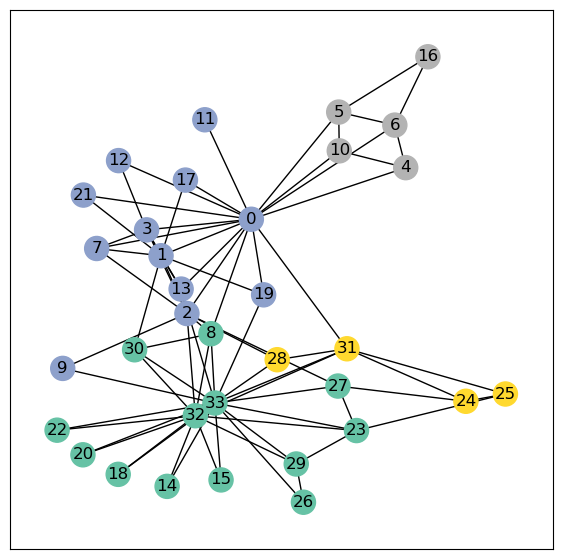

In [8]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [9]:
import torch 
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [10]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2023)
        self.conv1 = GCNConv(dataset.num_features, 8)
        self.conv2 = GCNConv(8, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)
        
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh() 
        h = self.conv3(h, edge_index)
        h = h.tanh() 
        
        out = self.classifier(h)
        
        return out, h
    
model = GCN() 
print(model)

GCN(
  (conv1): GCNConv(34, 8)
  (conv2): GCNConv(8, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape: [34, 2]


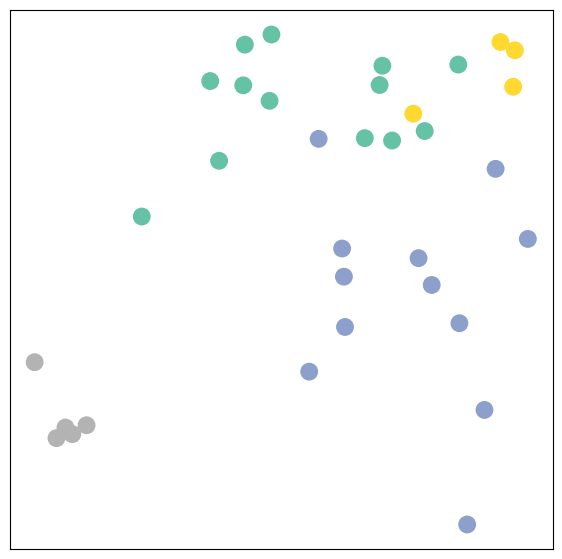

In [11]:
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
visualize_embedding(h, color=data.y)

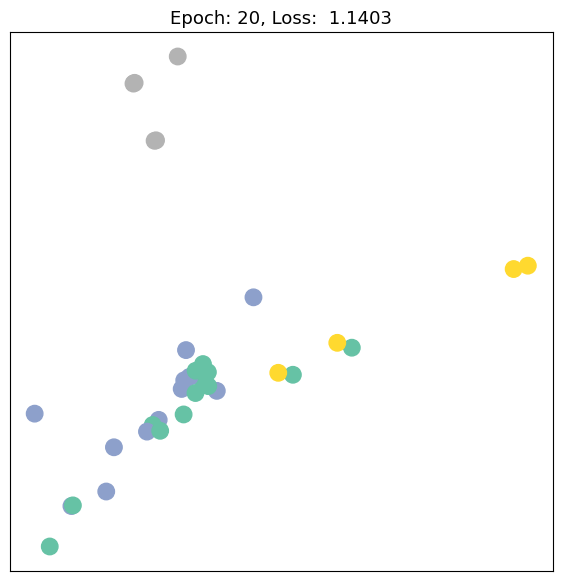

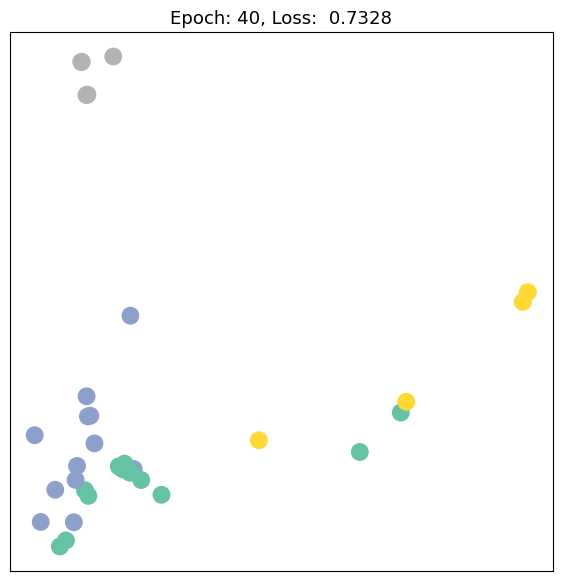

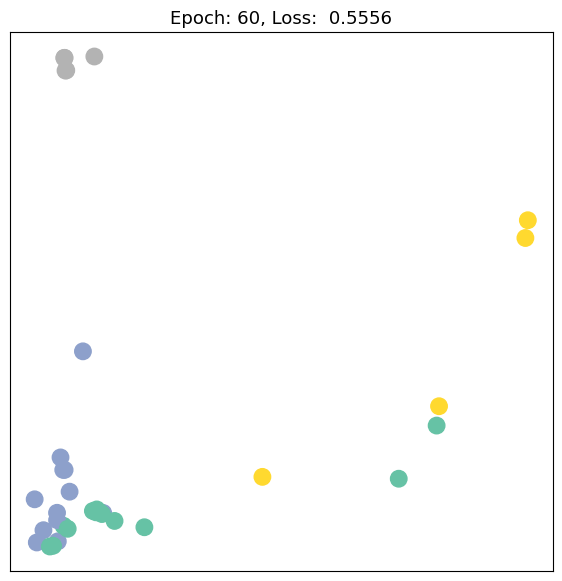

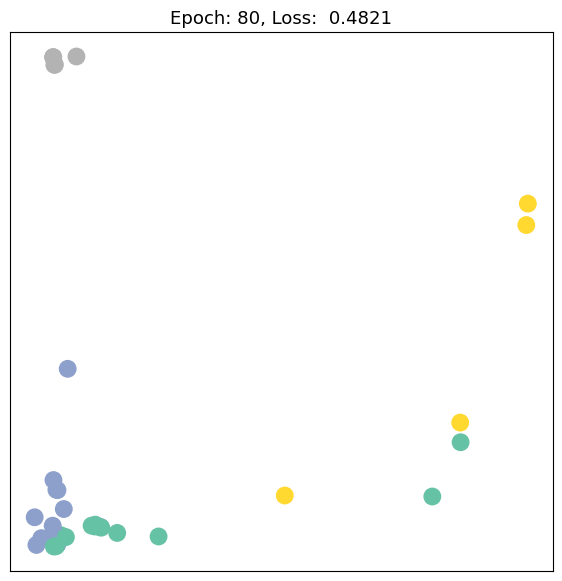

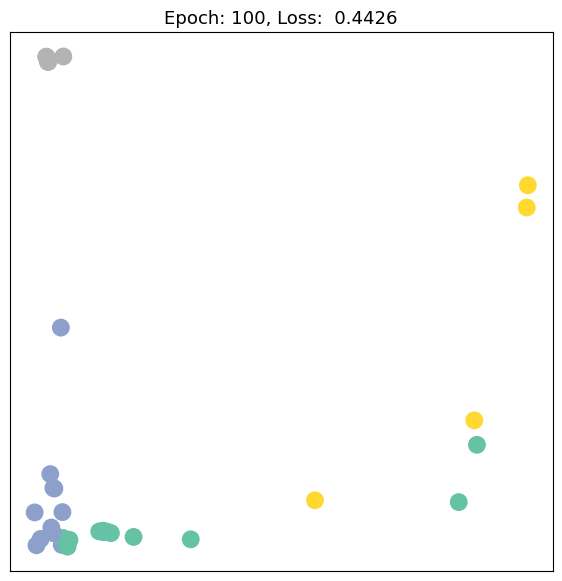

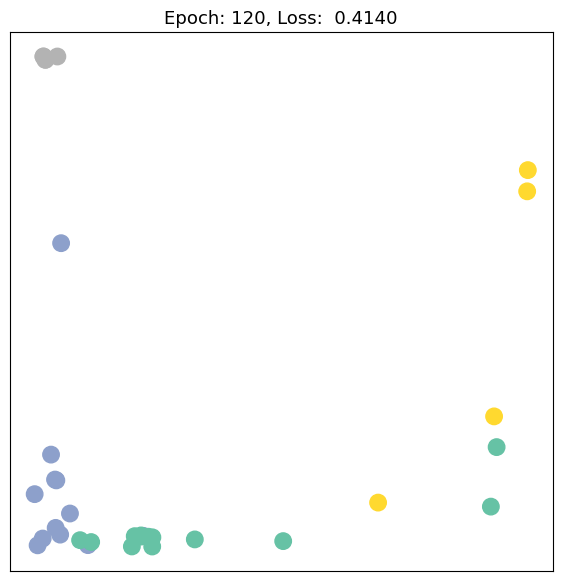

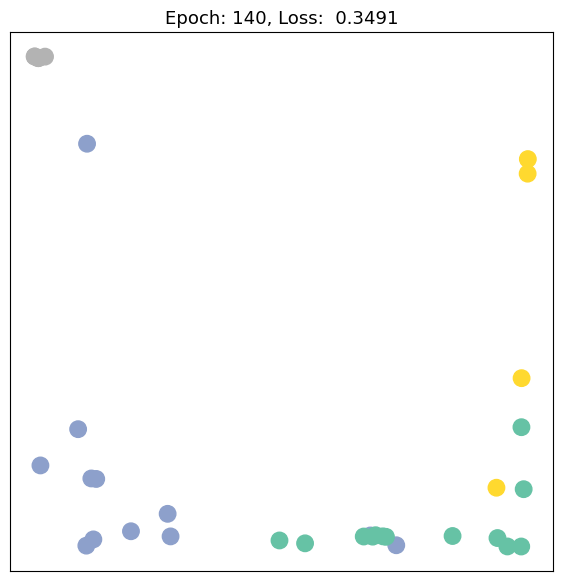

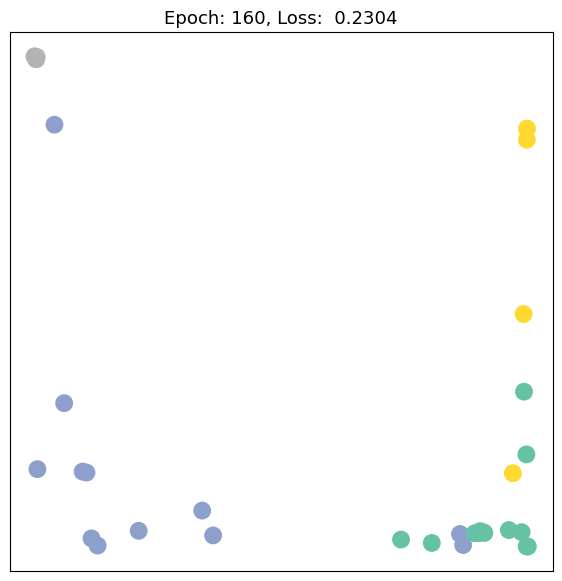

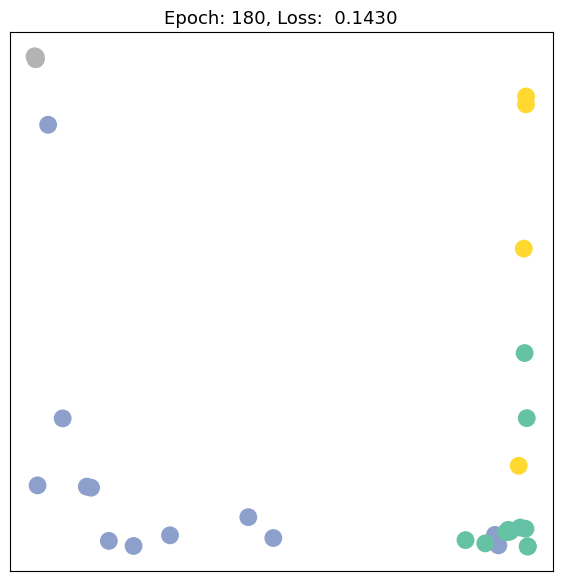

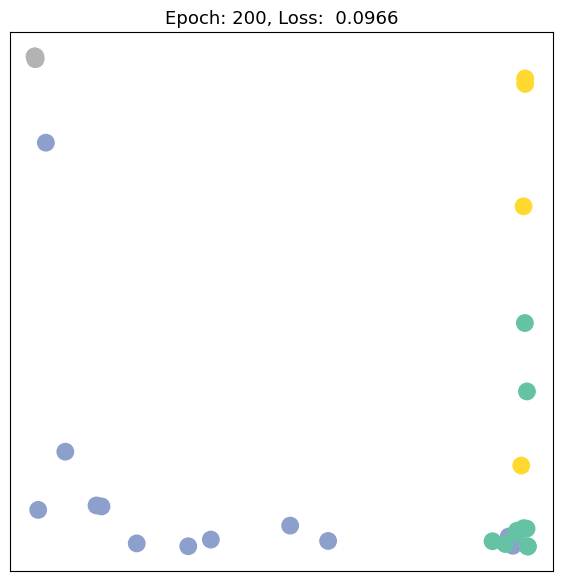

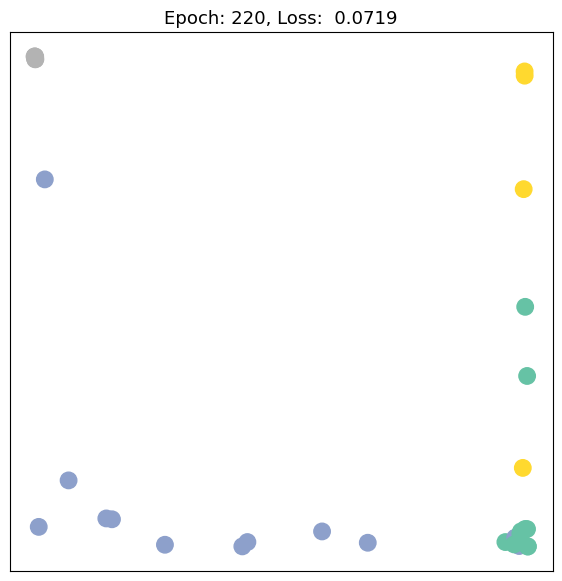

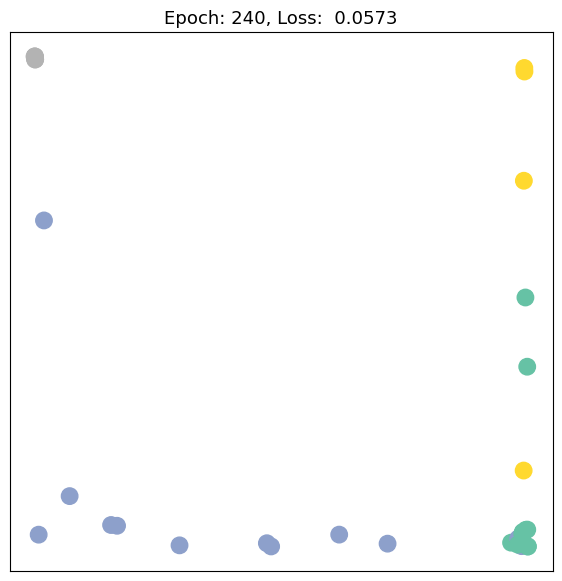

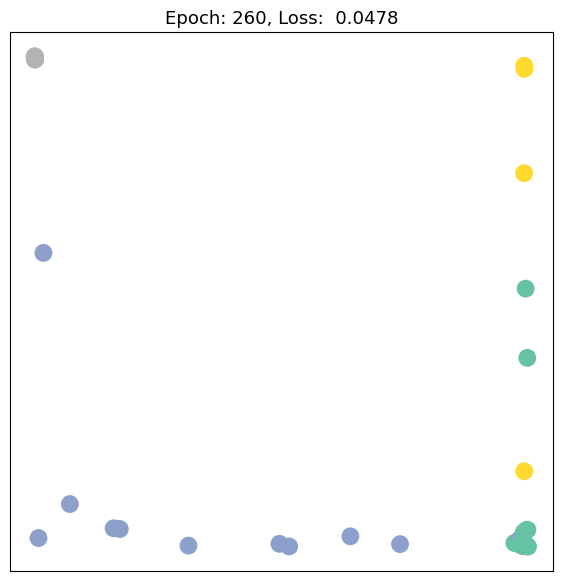

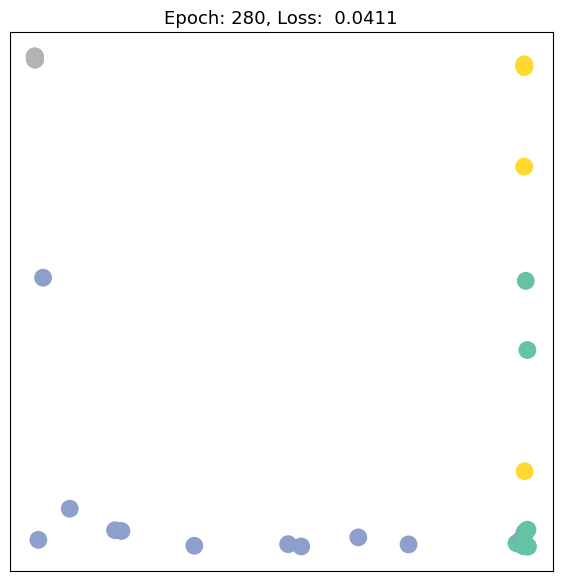

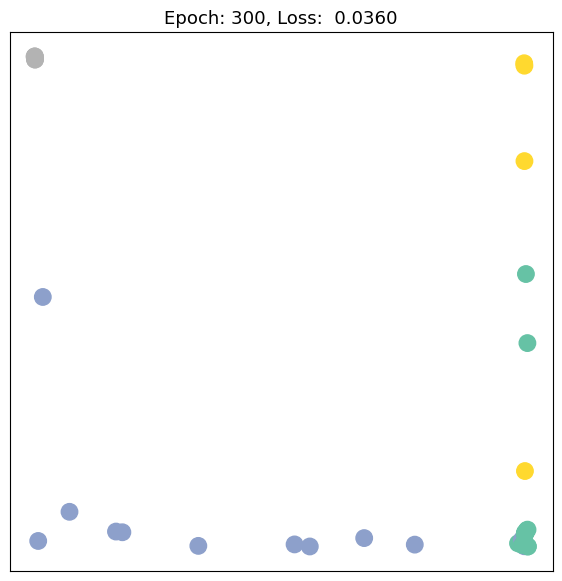

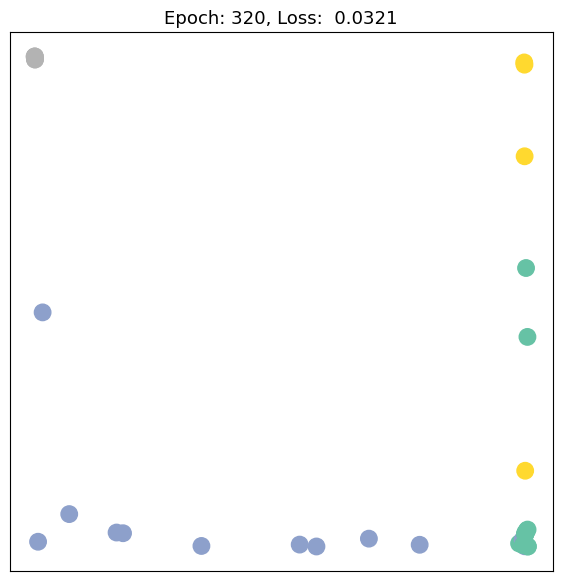

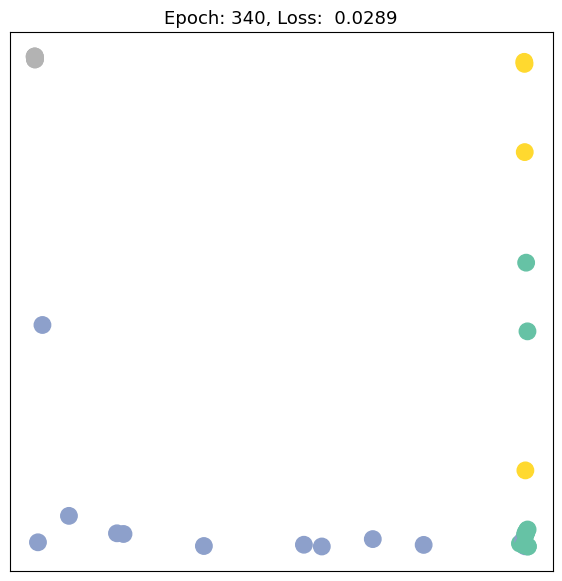

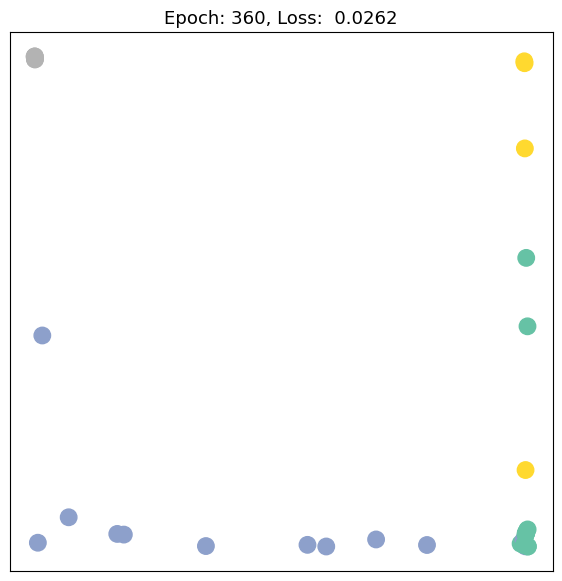

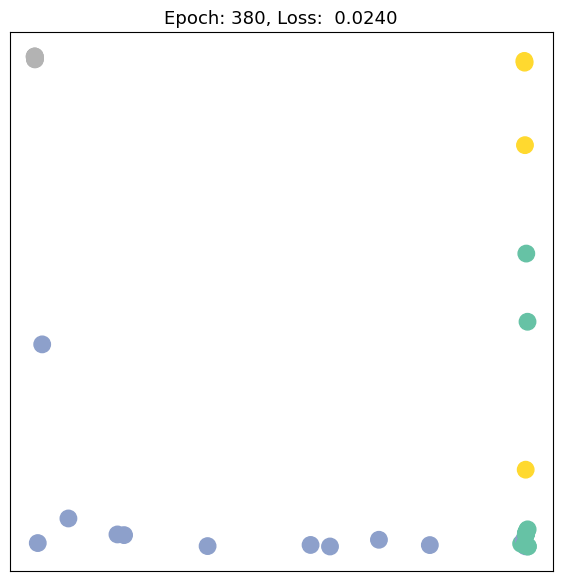

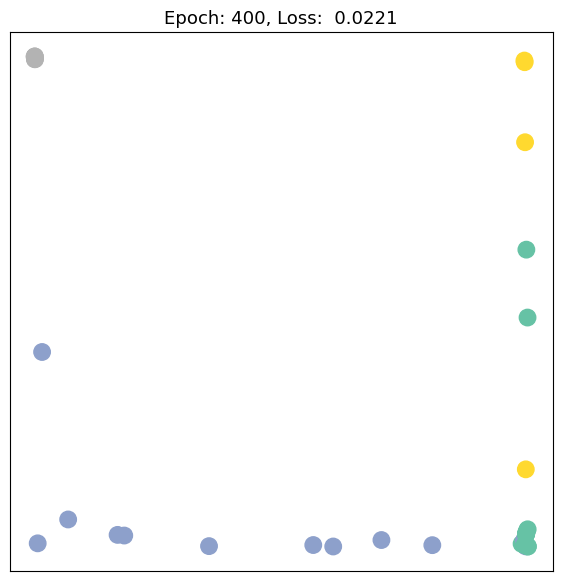

In [12]:
import time 

model = GCN() 
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    optimizer.zero_grad() 
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward() 
    optimizer.step() 
    return loss, h

for epoch in range(400):
    loss, h = train(data)
    if (epoch + 1) % 20 == 0:
        visualize_embedding(h, color=data.y, epoch=(epoch + 1), loss=loss)
        time.sleep(0.3)